# Продвинутое глубокое обучение и обучение с подкреплением: ДЗ 2

Студент: Бакулев Владимир Леонидович

Группа: MADE-DS-32

Почта: vlbakulev@gmail.com

In [1]:
import gym

import pickle

import numpy as np

# %matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt

##  Часть первая: крестики-нолики при помощи Q-обучения

В коде, прилагающемся к последней лекции про обучение с подкреплением, реализован Environment для крестиков-ноликов, в котором можно при инициализации указывать разные размеры доски и условия победы, а также функции для рисования, в том числе с указанием оценки различных действий. С этим окружением все задания и связаны.

1. Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.
2. Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

In [2]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=3, n_cols=3, n_win=3, clone=None):
        if clone is not None:
            self.n_rows, self.n_cols, self.n_win = clone.n_rows, clone.n_cols, clone.n_win
            self.board = copy.deepcopy(clone.board)
            self.curTurn = clone.curTurn
            self.emptySpaces = None
            self.boardHash = None
        else:
            self.n_rows = n_rows
            self.n_cols = n_cols
            self.n_win = n_win

            self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        print('╭', ('───┬' * self.n_cols)[:-1], '╮', sep='')
        for i in range(0, self.n_rows):
            if i != 0:
                print('├', ('───┼' * self.n_cols)[:-1], '┤', sep='')
            out = '│ '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' │ '
            print(out, sep='')
        print('╰', ('───┴' * self.n_cols)[:-1], '╯', sep='')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

In [3]:
def update_Q_for_new_state(env, Q_value, permissible_actions, current_state):
    """
    Функция создает Q_value для нового состояния, рандомно инициализирует 
    и отмечает невозможные действия
    """
    Q_s = np.random.rand(env.n_rows * env.n_cols) * -1.
    Q_s[[env.int_from_action(_act) for _act in permissible_actions]] *=  -1.
    Q_value[current_state] = Q_s
    return Q_value

def compute_action_for_state(env, Q_value, current_state):
    """
    Вычисляет действия по Q_value
    """
    Q_s = Q_value[current_state]
    return env.action_from_int(np.argmax(Q_s))

def epsilon_greed_policy(env, Q_value, permissible_actions, current_state, epsilon):
    """
    Эпсилон-жадная стратегия
    """
    action = None
    if np.random.rand() > epsilon:
        action = compute_action_for_state(env, Q_value, current_state)
    elif len(permissible_actions) > 0:
        action = permissible_actions[np.random.randint(len(permissible_actions))]
    return action

In [4]:
def X_Q_learning_episode(env, Q_value, alpha=0.02, epsilon=0.75, gamma=1.):
    """
    Функция для Q-обучения крестиков. Нолики одят рандомно, у крестиков цель - победить
    """
    env.reset()
    done = False
    
    # Инициализация
    current_state, permissible_actions = env.getHash(), env.getEmptySpaces()
    if Q_value.get(current_state) is None:
        Q_value = update_Q_for_new_state(env, Q_value, permissible_actions, current_state)
        
    action = epsilon_greed_policy(env, Q_value, permissible_actions, current_state, epsilon)

    while not done:
        
        reward = None
        
        if env.curTurn == 1:
            # Ход по обучаемой стратегии
            observation, reward, done, info = env.step(action)
        else:
            # Рандомный ход
            action = permissible_actions[np.random.randint(len(permissible_actions))]
            observation, reward, done, info = env.step(action)
        
        # Награду даем только за победу
        if reward < 0: 
            reward = 0
        
        # Q-обучение
        state_prime, permissible_actions = env.getHash(), env.getEmptySpaces()
        if Q_value.get(state_prime) is None:
            Q_value = update_Q_for_new_state(env, Q_value, permissible_actions, state_prime)
            
        action_prime = epsilon_greed_policy(env, Q_value, permissible_actions, state_prime, epsilon)
        
        current_Q_value = Q_value[current_state][env.int_from_action(action)]
        Q_value[current_state][env.int_from_action(action)] =  current_Q_value + alpha * (reward + gamma * np.max(Q_value[state_prime]) - current_Q_value)

        current_state, action = state_prime, action_prime
    
    return reward

In [5]:
def O_Q_learning_episode(env, Q_value, alpha=0.02, epsilon=0.75, gamma=1.):
    """
    Функция для Q-обучения ноликов. Крестики ходят рандомно, у ноликов цель - свести игру в ничью
    """
    env.reset()
    done = False
    
    # Первый ход делают крестики
    current_state, permissible_actions = env.getHash(), env.getEmptySpaces()
    action = permissible_actions[np.random.randint(len(permissible_actions))]
    
    observation, reward, done, info = env.step(action)
    
    # Инициализация
    current_state, permissible_actions = env.getHash(), env.getEmptySpaces()
    if Q_value.get(current_state) is None:
        Q_value = update_Q_for_new_state(env, Q_value, permissible_actions, current_state)
        
    action = epsilon_greed_policy(env, Q_value, permissible_actions, current_state, epsilon)

    while not done:
        
        reward = None
        
        if env.curTurn == -1:
            # Ход по обучаемой стратегии
            observation, reward, done, info = env.step(action)
        else:
            # Рандомный ход
            action = permissible_actions[np.random.randint(len(permissible_actions))]
            observation, reward, done, info = env.step(action)
        
        # Награду даем только за ничью
        if abs(reward) == 1: 
            reward = 0
        else:
            reward = 1
        
        # Q-обучение
        state_prime, permissible_actions = env.getHash(), env.getEmptySpaces()
        if Q_value.get(state_prime) is None:
            Q_value = update_Q_for_new_state(env, Q_value, permissible_actions, state_prime)
            
        action_prime = epsilon_greed_policy(env, Q_value, permissible_actions, state_prime, epsilon)
        
        current_Q_value = Q_value[current_state][env.int_from_action(action)]
        Q_value[current_state][env.int_from_action(action)] =  current_Q_value + alpha * (reward + gamma * np.max(Q_value[state_prime]) - current_Q_value)

        current_state, action = state_prime, action_prime
    
    return reward

In [6]:
def learning_episodes(env, total_episodes, Q_learning_episode, Q_value, save_filepath):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
    plt.ion()

    fig.show()
    fig.canvas.draw()

    list_reward = []
    list_mean_reward = []
    
    for n in range(1, total_episodes):

        reward = Q_learning_episode(env, Q_value, alpha=0.1, epsilon=0.75, gamma=1.)
        list_reward.append(reward)

        if n % 10_000 == 0:
            list_mean_reward.append(np.mean(list_reward[-10_000:])) 

            ax.clear()
            ax.plot(list_mean_reward)
            fig.canvas.draw()
            
        if n % 100_000 == 0:
            Q_dict = {
                "Q_value": Q_value,
                "history_reward": list_reward,
            }
            with open(save_filepath, 'wb') as f:
                pickle.dump(Q_dict, f)

In [7]:
def check_strategy(env, total_games, X_Q_value=None, O_Q_value=None):
    reward_X = 0
    reward_0 = 0
    
    for n in range(total_games):
    
        done = False
        env.reset()

        s, permissible_actions = env.getHash(), env.getEmptySpaces()

        while not done:

            if env.curTurn == 1:
                if X_Q_value is not None:
                    if X_Q_value.get(s) is not None:
                        action = compute_action_for_state(env, X_Q_value, s)
                    else:
                        action = permissible_actions[np.random.randint(len(permissible_actions))]
                else:
                    action = permissible_actions[np.random.randint(len(permissible_actions))]
            else:
                if O_Q_value is not None:
                    if O_Q_value.get(s) is not None:
                        action = compute_action_for_state(env, O_Q_value, s)
                    else:
                        action = permissible_actions[np.random.randint(len(permissible_actions))]
                else:
                    action = permissible_actions[np.random.randint(len(permissible_actions))]

            observation, reward, done, info = env.step(action)

            s, permissible_actions = env.getHash(), env.getEmptySpaces()

        if reward == 1:
            reward_X += 1
        elif reward == -1:
            reward_0 += 1
            
    total_reward_X = reward_X / total_games
    total_reward_0 = reward_0 / total_games
    dead_heat = 1 - (total_reward_X + total_reward_0)
    
    if X_Q_value is None and O_Q_value is None:
        print("Крестики и нолики играют по случайной стратегии:")
    elif X_Q_value is not None:
        print("Крестики играют по обученной стратегии, нолики играют по случайной стратегии:")
    elif O_Q_value is not None:
        print("Нолики играют по обученной стратегии, крестики играют по случайной стратегии:")
        
    print(f"Доля побед крестиков: {total_reward_X:.3f}")
    print(f"Доля побед ноликов: {total_reward_0:.3f}")
    print(f"Доля ничьих: {dead_heat:.3f}")
    print("=" * 40)

### Игра 3x3x3

##### Обучение крестиков

In [8]:
# env_3x3x3 = TicTacToe(n_rows=3, n_cols=3, n_win=3)
# X_Q_value_3x3x3 = {}

# learning_episodes(
#     env=env_3x3x3, 
#     total_episodes=10_000_000, 
#     Q_learning_episode=X_Q_learning_episode,
#     Q_value=X_Q_value_3x3x3, 
#     save_filepath="X_Q_value_3x3x3"
# )

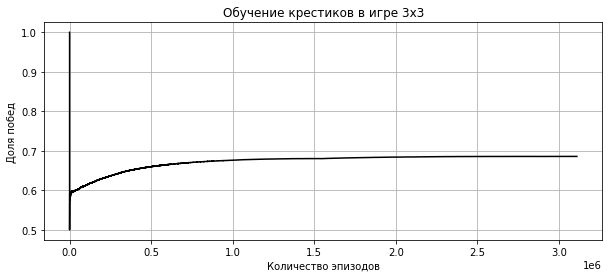

In [9]:
with open('X_Q_value_3x3x3', 'rb') as f:
    data_X_Q_value_3x3x3 = pickle.load(f)

X_Q_value_3x3x3 = data_X_Q_value_3x3x3["Q_value"]
history_reward_X_3x3x3 = data_X_Q_value_3x3x3["history_reward"]

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
axes.plot(np.cumsum(history_reward_X_3x3x3) / np.arange(1, len(history_reward_X_3x3x3) + 1), "k")
axes.set_xlabel("Количество эпизодов")
axes.set_ylabel("Доля побед")
axes.set_title("Обучение крестиков в игре 3х3")
axes.grid()

##### Обучение ноликов

In [10]:
# env_3x3x3 = TicTacToe(n_rows=3, n_cols=3, n_win=3)
# O_Q_value_3x3x3 = {}

# learning_episodes(
#     env=env_3x3x3, 
#     total_episodes=10_000_000, 
#     Q_learning_episode=O_Q_learning_episode,
#     Q_value=O_Q_value_3x3x3,
#     save_filepath="O_Q_value_3x3x3"
# )

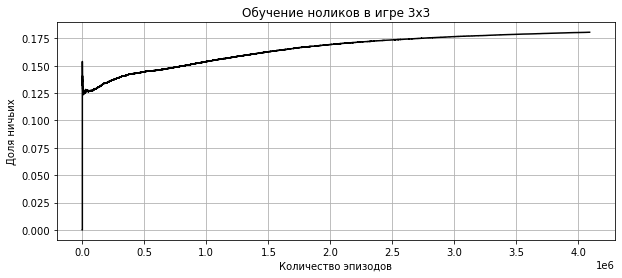

In [11]:
with open('O_Q_value_3x3x3', 'rb') as f:
    data_O_Q_value_3x3x3 = pickle.load(f)
    
O_Q_value_3x3x3 = data_O_Q_value_3x3x3["Q_value"]
history_reward_O_3x3x3 = data_O_Q_value_3x3x3["history_reward"]

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
axes.plot(np.cumsum(history_reward_O_3x3x3) / np.arange(1, len(history_reward_O_3x3x3) + 1), "k")
axes.set_xlabel("Количество эпизодов")
axes.set_ylabel("Доля ничьих")
axes.set_title("Обучение ноликов в игре 3х3")
axes.grid()

##### Проверка обученных стратегий

In [12]:
env_3x3x3 = TicTacToe(n_rows=3, n_cols=3, n_win=3)
total_games = 1_000

check_strategy(env_3x3x3, total_games, X_Q_value=None, O_Q_value=None)
check_strategy(env_3x3x3, total_games, X_Q_value=X_Q_value_3x3x3, O_Q_value=None)
check_strategy(env_3x3x3, total_games, X_Q_value=None, O_Q_value=O_Q_value_3x3x3)

Крестики и нолики играют по случайной стратегии:
Доля побед крестиков: 0.574
Доля побед ноликов: 0.295
Доля ничьих: 0.131
Крестики играют по обученной стратегии, нолики играют по случайной стратегии:
Доля побед крестиков: 0.918
Доля побед ноликов: 0.061
Доля ничьих: 0.021
Нолики играют по обученной стратегии, крестики играют по случайной стратегии:
Доля побед крестиков: 0.336
Доля побед ноликов: 0.075
Доля ничьих: 0.589


##### Выводы:


1. По случайной стратегии обоих игроков чаще выигрывают крестики, вдвое реже нолики, иногда ничьи
2. Обученные крестики практически всегда обыгрывают случайных ноликов
3. Ноликов можно обучить любую игру сводить к ничье (это априорно), но в нашем случае получилось свести к ничье только 53 % игр => нужно дообучать

### Игра 4x4x4

##### Обучение крестиков

In [13]:
# env_4x4x4 = TicTacToe(n_rows=4, n_cols=4, n_win=4)
# X_Q_value_4x4x4 = {}

# learning_episodes(
#     env=env_4x4x4, 
#     total_episodes=5_000_000, 
#     Q_learning_episode=X_Q_learning_episode,
#     Q_value=X_Q_value_4x4x4, 
#     save_filepath="X_Q_value_4x4x4"
# )

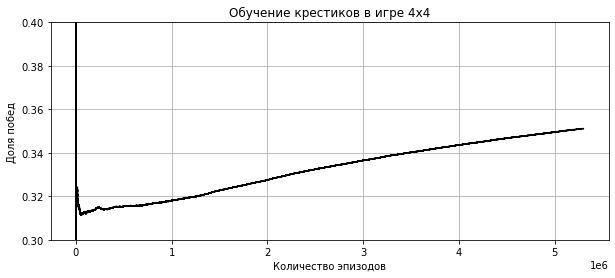

In [14]:
# with open('X_Q_value_4x4x4', 'rb') as f:
#     data_X_Q_value_4x4x4 = pickle.load(f)

# X_Q_value_4x4x4 = data_X_Q_value_4x4x4["Q_value"]
# history_reward_X_4x4x4 = data_X_Q_value_4x4x4["history_reward"]
# np.save("history_reward_X_Q_value_4x4x4.npy", np.array(history_reward_X_4x4x4))

history_reward_X_4x4x4 = np.load("history_reward_X_Q_value_4x4x4.npy")

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
axes.plot(np.cumsum(history_reward_X_4x4x4) / np.arange(1, len(history_reward_X_4x4x4) + 1), "k")
axes.set_ylim([0.3, 0.4])
axes.set_xlabel("Количество эпизодов")
axes.set_ylabel("Доля побед")
axes.set_title("Обучение крестиков в игре 4x4")
axes.grid()

##### Обучение ноликов

In [15]:
# env_4x4x4 = TicTacToe(n_rows=4, n_cols=4, n_win=4)
# O_Q_value_4x4x4 = {}

# learning_episodes(
#     env=env_4x4x4, 
#     total_episodes=2_000_000, 
#     Q_learning_episode=O_Q_learning_episode,
#     Q_value=O_Q_value_4x4x4,
#     save_filepath="O_Q_value_4x4x4"
# )

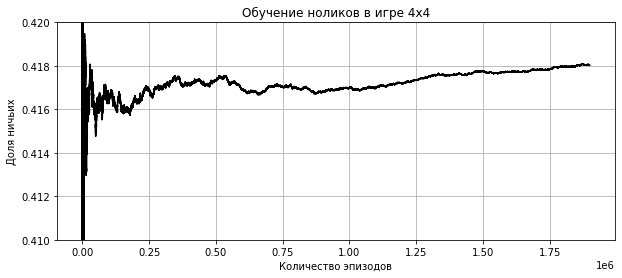

In [16]:
# with open('O_Q_value_4x4x4', 'rb') as f:
#     data_O_Q_value_4x4x4 = pickle.load(f)

# O_Q_value_4x4x4 = data_O_Q_value_4x4x4["Q_value"]
# history_reward_O_4x4x4 = data_O_Q_value_4x4x4["history_reward"]
# np.save("history_reward_O_Q_value_4x4x4.npy", np.array(history_reward_O_4x4x4))

history_reward_O_4x4x4 = np.load("history_reward_O_Q_value_4x4x4.npy")

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
axes.plot(np.cumsum(history_reward_O_4x4x4) / np.arange(1, len(history_reward_O_4x4x4) + 1), "k")
axes.set_ylim([0.41, 0.42])
axes.set_xlabel("Количество эпизодов")
axes.set_ylabel("Доля ничьих")
axes.set_title("Обучение ноликов в игре 4x4")
axes.grid()

##### Выводы:

Модели требуют отгромного времени для сходимости

## Часть вторая: добавим нейронных сетей

Реализуйте нейронную сеть для метода DQN на доске для крестиков-ноликов. Не буду ограничивать фантазию, но кажется, что свёртки 3х3 здесь должны неплохо работать (в том числе обобщаться на доски размера побольше).

3. Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.
4. Реализуйте Double DQN и/или Dueling DQN.

In [17]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam

from collections import deque
import random
import copy

In [18]:
GAMMA = 0.9

STEPS_PER_UPDATE = 16
BATCH_SIZE = 32
LEARNING_RATE = 5e-5
MAXLEN = 10_000

In [19]:
class LerningDQN:
    def __init__(self, model):
        self.steps = 0
        self.model = model
        self.criterion = nn.MSELoss()
        self.optimizer = Adam(self.model.parameters(), LEARNING_RATE)
        self.buffer = deque(maxlen=MAXLEN)

    def consume_transition(self, transition):
        self.buffer.append(transition)

    def sample_batch(self):
        batch = random.sample(self.buffer, BATCH_SIZE)
        return batch

    def train_step(self, batch):
        state, action, next_state, reward, done = zip(*batch)
        state = torch.tensor(np.array(state), dtype=torch.float)
        action = torch.tensor(np.array(action), dtype=torch.float)
        next_state = torch.tensor(np.array(next_state), dtype=torch.float)
        reward = torch.tensor(np.array(reward), dtype=torch.float)
        done = torch.tensor(np.array(done), dtype=torch.float)
        
        state = torch.squeeze(state)
        next_state = torch.squeeze(next_state)
        
        with torch.no_grad():
            q_value = self.model(state)
            q_value_next = self.model(next_state)
        
        
        q_value[torch.arange(q_value.size(0)), action.type(torch.LongTensor)] = reward + (1 - done) * GAMMA * torch.max(q_value_next, 1).values
        
        y_pred = self.model(state)
        loss = self.criterion(y_pred, q_value)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
            
    def act(self, state):
        with torch.no_grad():
            q = self.model(torch.Tensor(state))
            return torch.argmax(q).item()
            
    def update(self, transition):
        self.consume_transition(transition)
        
        if len(self.buffer) < BATCH_SIZE:
            return
        
        if self.steps % STEPS_PER_UPDATE == 0:
            batch = self.sample_batch()
            self.train_step(batch)
        self.steps += 1

    def save(self, filepath):
        torch.save(self.model.state_dict(), filepath)

In [20]:
def X_learning(env, agent, state_to_matrix, transition, filepath):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
    plt.ion()

    fig.show()
    fig.canvas.draw()

    list_reward = []
    list_mean_reward = []

    eps = 0.3

    for i in range(transition):

        env.reset()
        done = False

        while not done:

            state, permissible_actions = env.getHash(), env.getEmptySpaces()
            state_matrix = state_to_matrix(state)

            if env.curTurn == 1:

                if random.random() < eps and len(permissible_actions) > 0:
                    action = permissible_actions[np.random.randint(len(permissible_actions))]
                else:
                    action = env.action_from_int(agent.act(state_matrix))
            else:
                if len(permissible_actions) > 0:
                    action = permissible_actions[np.random.randint(len(permissible_actions))]

            (next_state, _, _), reward, done, info = env.step(action) 

            if reward < 0: 
                reward = 0

            action_int = env.int_from_action(action)
            next_state_matrix = state_to_matrix(next_state)

            agent.update((state_matrix, action_int, next_state_matrix, reward, done))

        list_reward.append(reward)

        if (i + 1) % 1_000 == 0:
            list_mean_reward.append(np.mean(list_reward[-1_000:])) 

            ax.clear()
            ax.plot(list_mean_reward)
            fig.canvas.draw()
            
        if (i + 1) % 1_000 == 0:
            agent.save(".".join([filepath, "pth"]))
            np.save(".".join([filepath, "npy"]), np.array(list_reward))

In [21]:
def O_learning(env, agent, state_to_matrix, transition, filepath):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
    plt.ion()

    fig.show()
    fig.canvas.draw()

    list_reward = []
    list_mean_reward = []

    eps = 0.3
    
    current_state, permissible_actions = env.getHash(), env.getEmptySpaces()
    action = permissible_actions[np.random.randint(len(permissible_actions))]
    env.step(action)

    for i in range(transition):

        env.reset()
        done = False

        while not done:

            state, permissible_actions = env.getHash(), env.getEmptySpaces()
            state_matrix = state_to_matrix(state)

            if env.curTurn == -1:

                if random.random() < eps and len(permissible_actions) > 0:
                    action = permissible_actions[np.random.randint(len(permissible_actions))]
                else:
                    action = env.action_from_int(agent.act(state_matrix))
            else:
                if len(permissible_actions) > 0:
                    action = permissible_actions[np.random.randint(len(permissible_actions))]

            (next_state, _, _), reward, done, info = env.step(action) 

            # Награду даем только за ничью
            if reward == -1: 
                reward = 1
            else:
                reward = 0

            action_int = env.int_from_action(action)
            next_state_matrix = state_to_matrix(next_state)

            agent.update((state_matrix, action_int, next_state_matrix, reward, done))

        list_reward.append(reward)

        if (i + 1) % 1_000 == 0:
            list_mean_reward.append(np.mean(list_reward[-1_000:])) 

            ax.clear()
            ax.plot(list_mean_reward)
            fig.canvas.draw()
            
        if (i + 1) % 1_000 == 0:
            agent.save(".".join([filepath, "pth"]))
            np.save(".".join([filepath, "npy"]), np.array(list_reward))

In [22]:
def state_to_matrix_3x3(state):
    state_matrix = []
    for s in list(state):
        state_row = np.zeros(3)
        state_row[int(s)] = 1
        state_matrix.append(state_row)
    
    state_matrix = np.array(state_matrix).T.reshape(3, 3, 3)
    return np.array([state_matrix])

In [23]:
def state_to_matrix_4x4(state):
    state_matrix = []
    for s in list(state):
        state_row = np.zeros(3)
        state_row[int(s)] = 1
        state_matrix.append(state_row)
    
    state_matrix = np.array(state_matrix).T.reshape(3, 4, 4)
    return np.array([state_matrix])

##### Обучение крестиков 3х3 базовым DQN

In [24]:
# env_3x3x3 = TicTacToe(n_rows=3, n_cols=3, n_win=3)

# dqn_X_3x3x3 = nn.Sequential(
#             nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3),
#             nn.ReLU(),
#             nn.Flatten(),
#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Linear(64, 9)
#         )

# agent_dqn_X_3x3x3 = LerningDQN(model=dqn_X_3x3x3)

# X_learning(
#     env=env_3x3x3, 
#     agent=agent_dqn_X_3x3x3,
#     state_to_matrix=state_to_matrix_3x3
#     transition=100_000, 
#     filepath="dqn_X_3x3x3"
# )

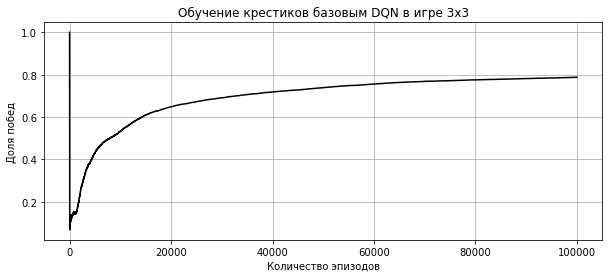

In [25]:
history_reward_X_3x3x3 = np.load("dqn_X_3x3x3.npy")

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
axes.plot(np.cumsum(history_reward_X_3x3x3) / np.arange(1, len(history_reward_X_3x3x3) + 1), "k")
axes.set_xlabel("Количество эпизодов")
axes.set_ylabel("Доля побед")
axes.set_title("Обучение крестиков базовым DQN в игре 3x3")
axes.grid()

##### Обучение ноликов 3х3 базовым DQN

In [26]:
# env_3x3x3 = TicTacToe(n_rows=3, n_cols=3, n_win=3)

# dqn_O_3x3x3 = nn.Sequential(
#             nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3),
#             nn.ReLU(),
#             nn.Flatten(),
#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Linear(64, 9)
#         )

# agent_dqn_O_3x3x3 = LerningDQN(model=dqn_O_3x3x3)

# O_learning(
#     env=env_3x3x3, 
#     agent=agent_dqn_O_3x3x3,
#     state_to_matrix=state_to_matrix_3x3,
#     transition=100_000, 
#     filepath="dqn_O_3x3x3"
# )

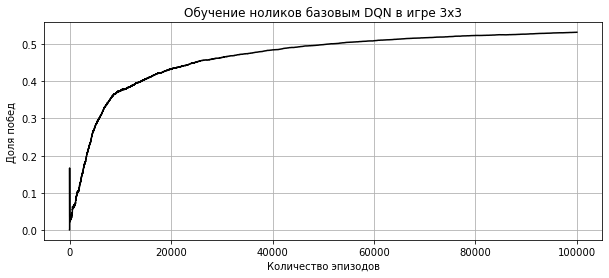

In [27]:
history_reward_O_3x3x3 = np.load("dqn_O_3x3x3.npy")

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
axes.plot(np.cumsum(history_reward_O_3x3x3) / np.arange(1, len(history_reward_O_3x3x3) + 1), "k")
axes.set_xlabel("Количество эпизодов")
axes.set_ylabel("Доля побед")
axes.set_title("Обучение ноликов базовым DQN в игре 3x3")
axes.grid()

##### Обучение крестиков 4x4x4 базовым DQN

In [28]:
# env_4x4x4 = TicTacToe(n_rows=4, n_cols=4, n_win=4)

# dqn_X_4x4x4 = nn.Sequential(
#             nn.Conv2d(in_channels=3, out_channels=128, kernel_size=4),
#             nn.ReLU(),
#             nn.Flatten(),
#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Linear(64, 16)
#         )

# agent_dqn_X_4x4x4 = LerningDQN(model=dqn_X_4x4x4)

# X_learning(
#     env=env_4x4x4, 
#     agent=agent_dqn_X_4x4x4, 
#     state_to_matrix=state_to_matrix_4x4,
#     transition=100_000, 
#     filepath="dqn_X_4x4x4"
# )

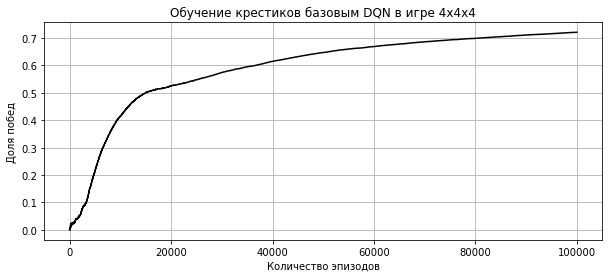

In [29]:
history_reward_X_4x4x4 = np.load("dqn_X_4x4x4.npy")

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
axes.plot(np.cumsum(history_reward_X_4x4x4) / np.arange(1, len(history_reward_X_4x4x4) + 1), "k")
axes.set_xlabel("Количество эпизодов")
axes.set_ylabel("Доля побед")
axes.set_title("Обучение крестиков базовым DQN в игре 4x4x4")
axes.grid()

##### Обучение ноликов 4x4x4 базовым DQN

In [30]:
# env_4x4x4 = TicTacToe(n_rows=4, n_cols=4, n_win=4)

# dqn_O_4x4x4 = nn.Sequential(
#             nn.Conv2d(in_channels=3, out_channels=128, kernel_size=4),
#             nn.ReLU(),
#             nn.Flatten(),
#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Linear(64, 16)
#         )

# agent_dqn_O_4x4x4 = LerningDQN(model=dqn_X_4x4x4)

# O_learning(
#     env=env_4x4x4, 
#     agent=agent_dqn_O_4x4x4, 
#     state_to_matrix=state_to_matrix_4x4,
#     transition=100_000, 
#     filepath="dqn_O_4x4x4"
# )

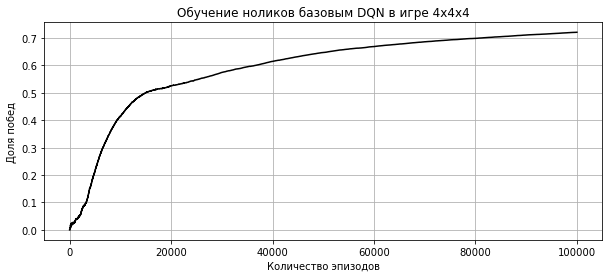

In [31]:
history_reward_O_4x4x4 = np.load("dqn_X_4x4x4.npy")

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
axes.plot(np.cumsum(history_reward_O_4x4x4) / np.arange(1, len(history_reward_O_4x4x4) + 1), "k")
axes.set_xlabel("Количество эпизодов")
axes.set_ylabel("Доля побед")
axes.set_title("Обучение ноликов базовым DQN в игре 4x4x4")
axes.grid()

#### DoubleDQN

In [32]:
STEPS_PER_TARGET_UPDATE = STEPS_PER_UPDATE * 1000

In [33]:
class LerningDoubleDQN:
    def __init__(self, model):
        self.steps = 0
        self.model = model
        self.criterion = nn.MSELoss()
        self.optimizer = Adam(self.model.parameters(), LEARNING_RATE)
        self.buffer = deque(maxlen=MAXLEN)
        self.target_model = copy.deepcopy(self.model)

    def consume_transition(self, transition):
        self.buffer.append(transition)

    def sample_batch(self):
        batch = random.sample(self.buffer, BATCH_SIZE)
        return batch

    def train_step(self, batch):
        state, action, next_state, reward, done = zip(*batch)
        state = torch.tensor(np.array(state), dtype=torch.float)
        action = torch.tensor(np.array(action), dtype=torch.float)
        next_state = torch.tensor(np.array(next_state), dtype=torch.float)
        reward = torch.tensor(np.array(reward), dtype=torch.float)
        done = torch.tensor(np.array(done), dtype=torch.float)
        
        state = torch.squeeze(state)
        next_state = torch.squeeze(next_state)
        
        with torch.no_grad():
            q_value = self.model(state)
            q_value_next = self.target_model(next_state)        
        
        q_value[torch.arange(q_value.size(0)), action.type(torch.LongTensor)] = reward + (1 - done) * GAMMA * torch.max(q_value_next, 1).values
        
        y_pred = self.model(state)
        loss = self.criterion(y_pred, q_value)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def update_target_network(self):
        self.target_model.load_state_dict(self.model.state_dict())
            
    def act(self, state, target=False):
        with torch.no_grad():
            q = self.model(torch.Tensor(state))
            return torch.argmax(q).item()
            
    def update(self, transition):
        self.consume_transition(transition)
        
        if len(self.buffer) < BATCH_SIZE:
            return
        
        if self.steps % STEPS_PER_UPDATE == 0:
            batch = self.sample_batch()
            self.train_step(batch)
            
        if self.steps % STEPS_PER_TARGET_UPDATE == 0:
            self.update_target_network()
            
        self.steps += 1

    def save(self, filepath):
        torch.save(self.model.state_dict(), filepath)

##### Обучение крестиков 3х3 DoubleDQN

In [34]:
# env_3x3x3 = TicTacToe(n_rows=3, n_cols=3, n_win=3)

# dqn_X_3x3x3 = nn.Sequential(
#             nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3),
#             nn.ReLU(),
#             nn.Flatten(),
#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Linear(64, 9)
#         )

# agent_doubledqn_X_3x3x3 = LerningDoubleDQN(model=dqn_X_3x3x3)

# X_learning(
#     env=env_3x3x3, 
#     agent=agent_doubledqn_X_3x3x3,
#     state_to_matrix=state_to_matrix_3x3,
#     transition=100_000, 
#     filepath="double_dqn_X_3x3x3"
# )

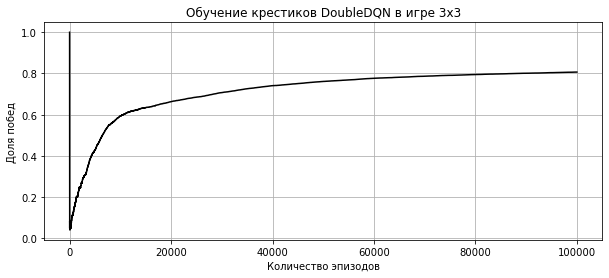

In [35]:
history_reward_X_3x3x3 = np.load("double_dqn_X_3x3x3.npy")

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
axes.plot(np.cumsum(history_reward_X_3x3x3) / np.arange(1, len(history_reward_X_3x3x3) + 1), "k")
axes.set_xlabel("Количество эпизодов")
axes.set_ylabel("Доля побед")
axes.set_title("Обучение крестиков DoubleDQN в игре 3x3")
axes.grid()

##### Обучение ноликов 3х3 DoubleDQN

In [36]:
# env_3x3x3 = TicTacToe(n_rows=3, n_cols=3, n_win=3)

# dqn_O_3x3x3 = nn.Sequential(
#             nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3),
#             nn.ReLU(),
#             nn.Flatten(),
#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Linear(64, 9)
#         )

# agent_doubledqn_O_3x3x3 = LerningDoubleDQN(model=dqn_O_3x3x3)

# O_learning(
#     env=env_3x3x3, 
#     agent=agent_doubledqn_O_3x3x3,
#     state_to_matrix=state_to_matrix_3x3,
#     transition=100_000, 
#     filepath="double_dqn_O_3x3x3"
# )

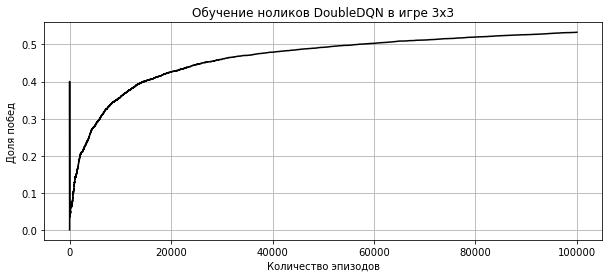

In [37]:
history_reward_O_3x3x3 = np.load("double_dqn_O_3x3x3.npy")

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
axes.plot(np.cumsum(history_reward_O_3x3x3) / np.arange(1, len(history_reward_O_3x3x3) + 1), "k")
axes.set_xlabel("Количество эпизодов")
axes.set_ylabel("Доля побед")
axes.set_title("Обучение ноликов DoubleDQN в игре 3x3")
axes.grid()

##### Обучение крестиков 4x4x4 DoubleDQN

In [38]:
# env_4x4x4 = TicTacToe(n_rows=4, n_cols=4, n_win=4)

# dqn_X_4x4x4 = nn.Sequential(
#             nn.Conv2d(in_channels=3, out_channels=128, kernel_size=4),
#             nn.ReLU(),
#             nn.Flatten(),
#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Linear(64, 16)
#         )

# agent_doubledqn_X_4x4x4 = LerningDoubleDQN(model=dqn_X_4x4x4)

# X_learning(
#     env=env_4x4x4, 
#     agent=agent_doubledqn_X_4x4x4,
#     state_to_matrix=state_to_matrix_4x4,
#     transition=100_000, 
#     filepath="double_dqn_X_4x4x4"
# )

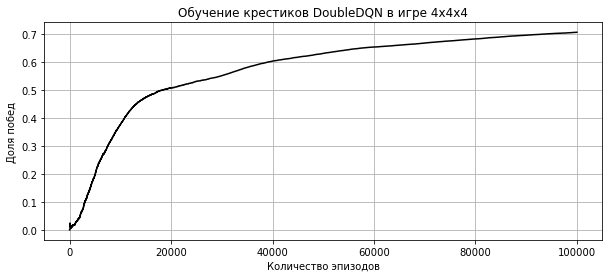

In [39]:
history_reward_X_4x4x4 = np.load("double_dqn_X_4x4x4.npy")

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
axes.plot(np.cumsum(history_reward_X_4x4x4) / np.arange(1, len(history_reward_X_4x4x4) + 1), "k")
axes.set_xlabel("Количество эпизодов")
axes.set_ylabel("Доля побед")
axes.set_title("Обучение крестиков DoubleDQN в игре 4x4x4")
axes.grid()

##### Обучение ноликов 4x4x4 DoubleDQN

In [40]:
# env_4x4x4 = TicTacToe(n_rows=4, n_cols=4, n_win=4)

# dqn_O_4x4x4 = nn.Sequential(
#             nn.Conv2d(in_channels=3, out_channels=128, kernel_size=4),
#             nn.ReLU(),
#             nn.Flatten(),
#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Linear(64, 16)
#         )

# agent_doubledqn_O_4x4x4 = LerningDoubleDQN(model=dqn_O_4x4x4)

# O_learning(
#     env=env_4x4x4, 
#     agent=agent_doubledqn_O_4x4x4,
#     state_to_matrix=state_to_matrix_4x4,
#     transition=100_000, 
#     filepath="double_dqn_O_4x4x4"
# )

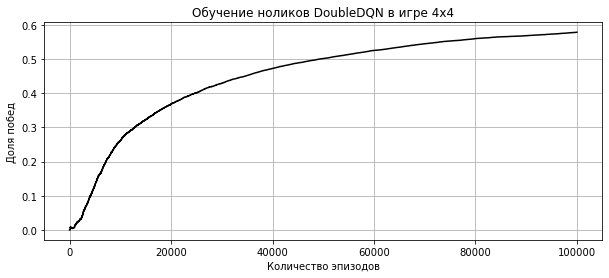

In [41]:
history_reward_O_4x4x4 = np.load("double_dqn_O_4x4x4.npy")

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
axes.plot(np.cumsum(history_reward_O_4x4x4) / np.arange(1, len(history_reward_O_4x4x4) + 1), "k")
axes.set_xlabel("Количество эпизодов")
axes.set_ylabel("Доля побед")
axes.set_title("Обучение ноликов DoubleDQN в игре 4x4")
axes.grid()

## Часть третья: расширим и углубим поиск

Крестики-нолики -- это, конечно, далеко не го, и обычный альфа-бета поиск с отсечением здесь наверняка может работать идеально вплоть до довольно больших досок. Однако мы всё-таки для этого учебного задания будем реализовывать более практически релевантный метод MCTS -- заодно фактически получится и упражнение на многоруких бандитов.
    
5. Реализуйте rollouts со случайной стратегией и (опционально) rollouts с неслучайной, но простой стратегией (например, основанной на дополнении нескольких паттернов или на Q-функции, которая у вас получилась в первом пункте).
6. Реализуйте MCTS-поиск с этими rollouts для крестиков-ноликов на досках разного размера, сравните полученные стратегии между собой и со стратегиями, обученными в первых двух частях.